# Import Libraries

In [559]:
import os
import re

import numpy as np
import pandas as pd

import keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, SimpleRNN, Dense, Dropout

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load corpus

### Load Positives

In [3]:
train_tweets, train_labels = [], []

pos = os.getcwd() + '/corpus/arabic_tweets/pos/'  # Replace with the actual directory path

# Iterate over each file in the directory
for filename in os.listdir(pos):
    if filename.endswith('.txt'):  # Select only text files
        file_path = os.path.join(pos, filename)
        with open(file_path, 'r', encoding='utf-8-sig') as file:
            file_content = file.read()
            train_tweets.append(file_content)
            train_labels.append("positive")

### Load Negatives

In [4]:
# Get the txt file negative tweet
pos = os.getcwd() + '/corpus/arabic_tweets/neg/'  # Replace with the actual directory path

# Iterate over each file in the directory
for filename in os.listdir(pos):
    if filename.endswith('.txt'):  # Select only text files
        file_path = os.path.join(pos, filename)
        with open(file_path, 'r', encoding='utf-8-sig') as file:
            file_content = file.read()
            train_tweets.append(file_content)
            train_labels.append("negative")

### Build a dataframe

In [447]:
train_dic = {
    'Tweets' : train_tweets,
    'Labels' : train_labels
}

train_corpus = pd.DataFrame(train_dic)
train_corpus.head()

,Tweets,Labels
0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,positive
1,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,positive
2,نمش ننوم ما دا ديل ولادنا 💚\n,positive
3,تعدل النت وشفتها ✌\n,positive
4,"🎥 المهمة الأولى في ""جدة"" ✔💪🏼 💙 #الهلال #فيديو_...",positive


# EDA

##### Explore your dataset

In [448]:
train_corpus.shape

(58751, 2)

In [449]:
train_corpus['Labels'].value_counts()

Labels
positive    29849
negative    28902
Name: count, dtype: int64

In [450]:
idx = train_corpus["Tweets"].apply(len).idxmax()

train_corpus.iloc[idx, :]

Tweets    كان له بيت وأهل وجيران،في حي آمن،في بلد أمين ك...
Labels                                             positive
Name: 862, dtype: object

In [451]:
train_corpus["Tweets"][idx]

'كان له بيت وأهل وجيران،في حي آمن،في بلد أمين كان له بيت وأهل وجيران،في حي آمن كان له بيت وأهل وجيران كان له بيت وأهل كان له بيت كان له كان 👤\n'

In [452]:
print(Tokenizer(train_corpus["Tweets"][idx]))

In [453]:
train_corpus['length'] = 0
def findlen(x):
    tokens = word_tokenize(x)
    return len(tokens)
    
train_corpus['length'] = train_corpus["Tweets"].apply(findlen)
train_corpus

,Tweets,Labels,length
0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,positive,20
1,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,positive,13
2,نمش ننوم ما دا ديل ولادنا 💚\n,positive,7
3,تعدل النت وشفتها ✌\n,positive,4
4,"🎥 المهمة الأولى في ""جدة"" ✔💪🏼 💙 #الهلال #فيديو_...",positive,13
...,...,...,...
58746,#أمي فقيدتي وأن مرت الأيام.. وبدأ الجميع بنسيا...,negative,23
58747,مره في السنه ما كل اسبوع عاد 😢\n,negative,8
58748,#يوم_الجمعه اسال الله عز وجل في هذا اليوم الفض...,negative,22
58749,يعني الغاء العقود الاولي كانت تسكيته لنا شسالف...,negative,19


In [454]:
import seaborn as sns

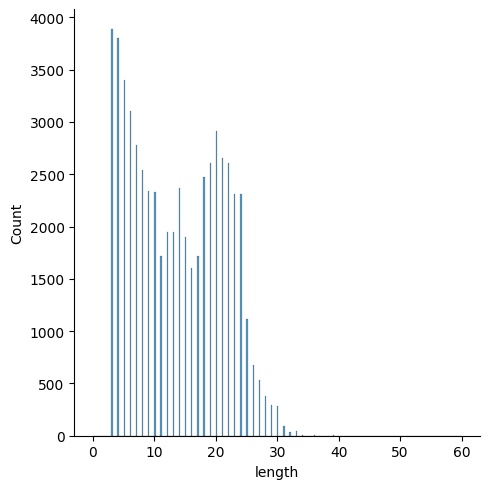

In [455]:
sns.displot(train_corpus['length'], bins=300)

In [456]:
train_corpus.describe()

,length
count,58751.000000
mean,13.599241
std,7.403306
min,0.000000
25%,7.000000
50%,13.000000
75%,20.000000
max,60.000000


<Axes: ylabel='length'>

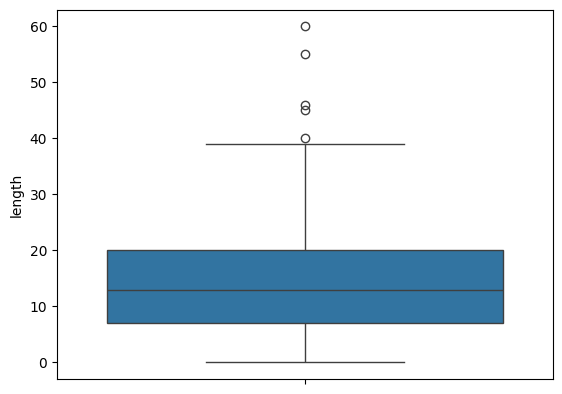

In [457]:
sns.boxplot(train_corpus['length'])

# Data Preprocessing

### Shuffle all rows

In [458]:
print(train_corpus.shape)
Q1 = train_corpus['length'].quantile(0.25)
Q3 = train_corpus['length'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers = train_corpus[(train_corpus['length'] < lower) | (train_corpus['length'] > upper)]
train_corpus = train_corpus.drop(outliers.index)
print(train_corpus.shape)

(58751, 3)
(58746, 3)


In [459]:
train_corpus.drop(columns='length', inplace=True)

In [460]:
train_corpus.head()

,Tweets,Labels
0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,positive
1,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,positive
2,نمش ننوم ما دا ديل ولادنا 💚\n,positive
3,تعدل النت وشفتها ✌\n,positive
4,"🎥 المهمة الأولى في ""جدة"" ✔💪🏼 💙 #الهلال #فيديو_...",positive


In [461]:
train_corpus['Labels'].value_counts()

Labels
positive    29844
negative    28902
Name: count, dtype: int64

In [462]:
train_corpus['Labels'] = train_corpus['Labels'].map({'positive' : 1, 'negative' : 0})
train_corpus

,Tweets,Labels
0,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء لل...,1
1,وفي النهاية لن يبقىٰ معك آحدإلا من رأىٰ الجمال...,1
2,نمش ننوم ما دا ديل ولادنا 💚\n,1
3,تعدل النت وشفتها ✌\n,1
4,"🎥 المهمة الأولى في ""جدة"" ✔💪🏼 💙 #الهلال #فيديو_...",1
...,...,...
58746,#أمي فقيدتي وأن مرت الأيام.. وبدأ الجميع بنسيا...,0
58747,مره في السنه ما كل اسبوع عاد 😢\n,0
58748,#يوم_الجمعه اسال الله عز وجل في هذا اليوم الفض...,0
58749,يعني الغاء العقود الاولي كانت تسكيته لنا شسالف...,0


In [463]:
train_corpus = train_corpus.sample(frac = 1)

In [464]:
train_corpus.head()

,Tweets,Labels
19508,اي والله مستحيل لا أراها تستقل 💛\n,1
19659,نرجع للخمسات 😉\n,1
18646,لا تعلق سعادتك بغير الله فإن الحبيب يجفو والقر...,1
1904,وكن لنفسك كل شي ❤ #سعودي_ولي_الفخر\n,1
49692,شي يؤلم لمكانة المرأة السعودية ،، كنا ننتظر مك...,0


### Data cleaning

**Hint: remove URLs, Hashtags, alphanumeric characters, punctuation marks, stop words, extra spaces**

In [465]:
URL_pattern = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
hashtag_pattern = r"#\w+"
mention_pattern = r"@\w+"
alphanumeric_pattern = r"\w*\d\w*"
punctuation_pattern = r"[^\w\s]"
retweet_pattern = r"^RT[\s]+"

In [466]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
    return frozenset(stop_set)

def process_text(text, stop_words):
    # Remove URLs
    text = re.sub(URL_pattern, '', text)
    
    # Remove hashtags
    text = re.sub(hashtag_pattern, '', text)
    
    # Remove mention
    text = re.sub(mention_pattern, '', text)

    # Remove alphanuSmeric characters
    text = re.sub(alphanumeric_pattern, '', text)

    # Remove punctuation marks
    text = re.sub(punctuation_pattern, '', text)
    
    # Remove Retweet marks
    text = re.sub(retweet_pattern, '', text)

    # Remove stop words using the provided set
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = ' '.join(text.split())
    return text

#### Now Clean your text using above function or implement it from scrach

In [467]:
stop_words = load_stopwords('corpus/Stop_Words.txt')
len(stop_words)

162

In [468]:
df = pd.DataFrame(columns=['text'])
df['text'] = [process_text(sen, stop_words) for sen in train_corpus['Tweets'][:3000]]
df

,text
0,والله مستحيل أراها تستقل
1,نرجع للخمسات
2,تعلق سعادتك بغير الله فإن الحبيب يجفو والقريب ...
3,وكن لنفسك شي
4,شي يؤلم لمكانة المرأة السعودية كنا ننتظر مكانت...
...,...
2995,ايش هالترويج ياليتك نزلتيه الفجر لمن تعبنا ونمنا
2996,شهور تستاهل الزرقاء
2997,ربي دعوتگ امرتني فاستجب لي گما وعدتني
2998,أبشرك غيابك راتبي صفالي كامل اعلم الكاتب بس شك...


In [469]:
df.dtypes

text    object
dtype: object

In [470]:
#df['text'] = df['text'].astype("str").astype("string")
#df.dtypes

#### Extra: you could do stemming or lemmatization before training

In [471]:
from tashaphyne.stemming import ArabicLightStemmer
import arabicstopwords.arabicstopwords as stp
ArListem = ArabicLightStemmer()

In [472]:
def text_root(text):
    tokens = word_tokenize(text)
    
    tokens = [w.strip() for w in tokens if not re.match(r'[A-Z]+', w, re.I)]

    NoStopTokens = [i.strip() for i in tokens if stp.is_stop(i) == False]
    
    text = ''
    for word in NoStopTokens:
        newword= ArListem.light_stem(word);
        root=ArListem.get_root()
        text += root.encode('utf8').decode("utf-8").strip() + ' '
    
    return text

In [473]:
def text_Stem(text):
    tokens = word_tokenize(text)

    tokens = [w for w in tokens if not re.match(r'[A-Z]+', w, re.I)]

    NoStopTokens = [i for i in tokens if stp.is_stop(i) == False]
    
    stem_words = [ArListem.light_stem(i) for i in NoStopTokens]
    text = " ".join(x for x in stem_words)
    
    return text

In [477]:
print('original : ',df['text'][2])
print('Stem : ', text_Stem(df['text'][2]))
print('Root : ', text_root(df['text'][2]))

original :  تعلق سعادتك بغير الله فإن الحبيب يجفو والقريب يبعد والحي يموت والمال يفنى والصحة تزول يبقى إلا الحي القيوم
Stem :  علق سعاد له حبيب جفو قريب بعد حي موت مال فنى صح زول بقى حي قيوم
Root :  علق سعد لهه حبب جفف قرب بعد ولح موت لمل فني صحح زول بقي ولح لقم 


In [478]:
df['text'] = df['text'].apply(text_Stem)
df

,text
0,له مستحيل را ستقل
1,رجع خمس
2,علق سعاد له حبيب جفو قريب بعد حي موت مال فنى ص...
3,كن شي
4,شي ؤلم مكان مرأ سعود نا نتظر مكان قم هرم
...,...
2995,يش هالترويج يال نزلت فجر عب منا
2996,شهور تستاهل زرقاء
2997,رب دعوتگ مرت ستجب گم عد
2998,شر غياب راتب صفال امل علم كاتب شكل خروف طيب


In [482]:
df['Labels'] = train_corpus['Labels'][:3000].values
df

,text,Labels
0,له مستحيل را ستقل,1
1,رجع خمس,1
2,علق سعاد له حبيب جفو قريب بعد حي موت مال فنى ص...,1
3,كن شي,1
4,شي ؤلم مكان مرأ سعود نا نتظر مكان قم هرم,0
...,...,...
2995,يش هالترويج يال نزلت فجر عب منا,0
2996,شهور تستاهل زرقاء,1
2997,رب دعوتگ مرت ستجب گم عد,0
2998,شر غياب راتب صفال امل علم كاتب شكل خروف طيب,1


In [484]:
df.dtypes

text      object
Labels     int64
dtype: object

# Tokenizer

In [628]:
corpus = df["text"].astype(str).tolist()

tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(corpus) 

# Text to sequence

In [629]:
sequences = tokenizer.texts_to_sequences(corpus)
num_classes = len(tokenizer.word_index) + 1

print("Total number of words: ", num_classes)

Total number of words:  6368


# Pad sequence

In [647]:
max_sequence_length = max([len(seq) for seq in sequences])
input_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [650]:
input_sequences

array([[   0,    0,    0, ...,  628,   71, 2761],
       [   0,    0,    0, ...,    0,   81,  731],
       [   0,    0,    0, ...,  201,  105, 2763],
       ...,
       [   0,    0,    0, ..., 1415,  592,  186],
       [   0,    0,    0, ...,  211, 2274,   82],
       [   0,    0,    0, ...,  679,    6, 6367]])

In [651]:
np.shape(input_sequences), np.shape(df['Labels'])

((3000, 24), (3000,))

# Split data to train and test

In [653]:
from sklearn.model_selection import train_test_split
X, y = input_sequences, df['Labels']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2010, 24), (2010,), (990, 24), (990,))

# RNN Model

In [654]:
from keras.layers import *
from keras.models import Sequential

In [655]:
RNN = Sequential()
RNN.add(Embedding(len(tokenizer.index_word)+1, 32))
RNN.add(SimpleRNN(91, return_sequences=True))
RNN.add(SimpleRNN(71))
RNN.add(Dense(1, activation='sigmoid'))

RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [656]:
%%time
RNN_epochs_hist = RNN.fit(X_train,y_train, epochs=10, batch_size=25)

Epoch 1/10
81/81 [==============================] - 4s 13ms/step - loss: 0.6760 - accuracy: 0.5448
Epoch 2/10
81/81 [==============================] - 1s 12ms/step - loss: 0.3652 - accuracy: 0.8333
Epoch 3/10
81/81 [==============================] - 1s 14ms/step - loss: 0.1238 - accuracy: 0.9537
Epoch 4/10
81/81 [==============================] - 1s 14ms/step - loss: 0.0570 - accuracy: 0.9776
Epoch 5/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0362 - accuracy: 0.9891
Epoch 6/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0247 - accuracy: 0.9930
Epoch 7/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0220 - accuracy: 0.9915
Epoch 8/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0190 - accuracy: 0.9940
Epoch 9/10
81/81 [==============================] - 1s 13ms/step - loss: 0.0164 - accuracy: 0.9945
Epoch 10/10
81/81 [==============================] - 1s 14ms/step - loss: 0.0134 - accuracy: 0.9945
CPU times

In [657]:
%%time
RNN_predict = RNN.predict(X_test) 

31/31 [==============================] - 1s 8ms/step
CPU times: total: 594 ms
Wall time: 877 ms


# LSTM Model

In [658]:
lstm = Sequential()
lstm.add(Embedding(len(tokenizer.index_word)+1, 32))
lstm.add(LSTM(133))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [659]:
%%time
lstm_epochs_hist = lstm.fit(X_train,y_train, epochs=10, batch_size=25)

Epoch 1/10
81/81 [==============================] - 6s 20ms/step - loss: 0.6890 - accuracy: 0.5323
Epoch 2/10
81/81 [==============================] - 2s 21ms/step - loss: 0.5177 - accuracy: 0.7517
Epoch 3/10
81/81 [==============================] - 1s 19ms/step - loss: 0.2751 - accuracy: 0.8930
Epoch 4/10
81/81 [==============================] - 2s 19ms/step - loss: 0.1432 - accuracy: 0.9488
Epoch 5/10
81/81 [==============================] - 2s 19ms/step - loss: 0.0805 - accuracy: 0.9711
Epoch 6/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0557 - accuracy: 0.9811
Epoch 7/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0417 - accuracy: 0.9846
Epoch 8/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0328 - accuracy: 0.9881
Epoch 9/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0342 - accuracy: 0.9886
Epoch 10/10
81/81 [==============================] - 2s 20ms/step - loss: 0.0229 - accuracy: 0.9915
CPU times

In [660]:
%%time
lstm_predict = lstm.predict(X_test) 

31/31 [==============================] - 1s 9ms/step
CPU times: total: 797 ms
Wall time: 1.13 s


# Evaulation and Comparsion

In [661]:
eva = pd.DataFrame(columns = ['True', 'RNN_predict', 'LSTM_predict'])
eva['True'] = y_test
eva['RNN_predict'] = [1 if i >.5 else 0 for i in RNN_predict ]
eva['LSTM_predict'] = [1 if i >.5 else 0 for i in lstm_predict ]

eva

,True,RNN_predict,LSTM_predict
1801,1,0,1
1190,1,1,1
1817,1,0,1
251,0,1,0
2505,0,0,0
...,...,...,...
2468,0,0,0
2013,1,1,0
714,0,0,0
803,1,1,1


In [662]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [663]:
def eval(predictions):
    print('The accuracy of the model : ', round(accuracy_score(eva['True'], predictions), 3))
    print('The precision of the model : ', round(precision_score(eva['True'], predictions), 3))
    print('The recall of the model : ', round(recall_score(eva['True'], predictions), 3))
    print('The f1 score of the model : ', round(f1_score(eva['True'], predictions), 3))
    print('\nThe classification_report of the model :\n\n', classification_report(eva['True'], predictions))

In [664]:
print('RNN :\n')
eval(eva['RNN_predict'])
print('\n')
print('LSTM :\n')
eval(eva['LSTM_predict'])

RNN :

The accuracy of the model :  0.601
The precision of the model :  0.611
The recall of the model :  0.62
The f1 score of the model :  0.615

The classification_report of the model :

               precision    recall  f1-score   support

           0       0.59      0.58      0.59       480
           1       0.61      0.62      0.62       510

    accuracy                           0.60       990
   macro avg       0.60      0.60      0.60       990
weighted avg       0.60      0.60      0.60       990



LSTM :

The accuracy of the model :  0.616
The precision of the model :  0.633
The recall of the model :  0.606
The f1 score of the model :  0.619

The classification_report of the model :

               precision    recall  f1-score   support

           0       0.60      0.63      0.61       480
           1       0.63      0.61      0.62       510

    accuracy                           0.62       990
   macro avg       0.62      0.62      0.62       990
weighted avg       

**guess this is an example of overfitting or there might be another problem as i have high acc on training and low acc on texting**